In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import time
from collections import Counter

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,2
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,2
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,2
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,2
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,2
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,2
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,5


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,23.106483,32.582493,27.565409,30.876848,37.871074,29.134982,27.761127,35.521065,29.604090,24.551559,...,0.318874,-0.225162,19.638473,34.256842,7.520992,24.714286,10.690959,1,19,1
1,29.771870,30.540136,38.520122,31.575355,33.003326,30.040040,27.814507,29.182273,26.057108,25.789266,...,-0.057603,-0.086421,19.091309,33.310452,7.897223,26.785911,10.094512,1,19,1
2,40.222779,46.404687,44.055200,25.639727,29.444417,35.079406,28.513523,29.973095,27.075701,31.131923,...,0.302401,0.124125,9.798837,22.377805,7.876698,16.552705,6.132130,1,19,1
3,157.791235,31.193488,55.531232,39.627741,45.212171,32.861611,39.397306,28.941284,31.628126,27.823589,...,-0.084267,-0.378302,6.353691,25.077621,5.903288,12.308770,5.179532,1,19,1
4,82.622822,47.930386,38.044725,37.535223,40.376700,37.955920,39.897148,30.238509,31.283676,37.083677,...,0.104979,0.225488,6.753411,18.901389,6.012091,11.373749,3.892619,1,19,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train[['h_target', 'target']]
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test[['h_target', 'target']]

In [10]:
print(train_X.shape)
print(test_X.shape)

(27803, 129)
(6919, 129)


In [11]:
%%file dnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

class DNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=35, validation_split=0.05,
                       a_epochs=50, a_batch_size=25,
                       i_epochs=50, i_batch_size=25,
                       verbose=1, proc=None
                ):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        if self.proc:
            X = self.proc.fit_transform(X, y[:,1])
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=dims,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=dims,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=dims,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        if self.proc:
            X = self.proc.transform(np.array(X))
    
        for x in X:
            prob = self.clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze()
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
                i_pred = self.i_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        if self.proc:
            X = self.proc.transform(np.array(X))
        
#         print(self.a_clf.classes_)
#         print(self.i_clf.classes_)
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,0]).T
        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,1]).T

        probs = []
        
        for i in range(0, len(prob_a)):
            tmp = [None] * 50
            for counter, j in enumerate(self.a_clf.classes_):
                tmp[j] = prob_a[i][counter]
            for counter, j in enumerate(self.i_clf.classes_):
                tmp[j] = prob_i[i][counter]
            probs.append(tmp)
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])


        return model

    def deep_net_a(self, feature_count):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting dnnmult.py


## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [12]:
from dnnmult import DNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

proc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50))
])

clf = DNN_Multilayer(proc=proc)

clf.fit(train_X, train_y)

Train on 26412 samples, validate on 1391 samples
Epoch 1/50
26412/26412 [==============================] - 2s 92us/step - loss: 0.5893 - acc: 0.6875 - val_loss: 0.5608 - val_acc: 0.7203
Epoch 2/50
26412/26412 [==============================] - 2s 83us/step - loss: 0.5510 - acc: 0.7202 - val_loss: 0.5347 - val_acc: 0.7412
Epoch 3/50
26412/26412 [==============================] - 2s 85us/step - loss: 0.5272 - acc: 0.7399 - val_loss: 0.5208 - val_acc: 0.7592
Epoch 4/50
26412/26412 [==============================] - 2s 83us/step - loss: 0.5082 - acc: 0.7543 - val_loss: 0.4969 - val_acc: 0.7872
Epoch 5/50
26412/26412 [==============================] - 2s 82us/step - loss: 0.4917 - acc: 0.7677 - val_loss: 0.5337 - val_acc: 0.7764
Epoch 6/50
26412/26412 [==============================] - 2s 81us/step - loss: 0.4813 - acc: 0.7713 - val_loss: 0.4948 - val_acc: 0.7771
Epoch 7/50
26412/26412 [==============================] - 2s 78us/step - loss: 0.4721 - acc: 0.7784 - val_loss: 0.4904 - val_acc:

Epoch 10/50
9181/9181 [==============================] - 1s 104us/step - loss: 1.5321 - acc: 0.5007 - val_loss: 2.3192 - val_acc: 0.3099
Epoch 11/50
9181/9181 [==============================] - 1s 101us/step - loss: 1.4605 - acc: 0.5179 - val_loss: 2.4809 - val_acc: 0.2872
Epoch 12/50
9181/9181 [==============================] - 1s 96us/step - loss: 1.4220 - acc: 0.5387 - val_loss: 2.4297 - val_acc: 0.3037
Epoch 13/50
9181/9181 [==============================] - 1s 101us/step - loss: 1.3620 - acc: 0.5540 - val_loss: 2.5063 - val_acc: 0.3058
Epoch 14/50
9181/9181 [==============================] - 1s 102us/step - loss: 1.3100 - acc: 0.5735 - val_loss: 2.4786 - val_acc: 0.3099
Epoch 15/50
9181/9181 [==============================] - 1s 104us/step - loss: 1.2606 - acc: 0.5896 - val_loss: 2.5961 - val_acc: 0.2996
Epoch 16/50
9181/9181 [==============================] - 1s 105us/step - loss: 1.2078 - acc: 0.6054 - val_loss: 2.5894 - val_acc: 0.2913
Epoch 17/50
9181/9181 [===================

17231/17231 [==============================] - 2s 97us/step - loss: 1.3545 - acc: 0.5556 - val_loss: 2.7334 - val_acc: 0.3252
Epoch 20/50
17231/17231 [==============================] - 2s 105us/step - loss: 1.3162 - acc: 0.5686 - val_loss: 2.7793 - val_acc: 0.3330
Epoch 21/50
17231/17231 [==============================] - 2s 102us/step - loss: 1.3014 - acc: 0.5714 - val_loss: 2.8570 - val_acc: 0.3374
Epoch 22/50
17231/17231 [==============================] - 2s 99us/step - loss: 1.2642 - acc: 0.5831 - val_loss: 3.0582 - val_acc: 0.3352
Epoch 23/50
17231/17231 [==============================] - 2s 107us/step - loss: 1.2394 - acc: 0.5893 - val_loss: 2.8096 - val_acc: 0.3319
Epoch 24/50
17231/17231 [==============================] - 2s 102us/step - loss: 1.2118 - acc: 0.5985 - val_loss: 2.9504 - val_acc: 0.3208
Epoch 25/50
17231/17231 [==============================] - 2s 104us/step - loss: 1.1932 - acc: 0.6055 - val_loss: 2.8673 - val_acc: 0.3164
Epoch 26/50
17231/17231 [================

DNN_Multilayer(a_batch_size=25, a_epochs=50, batch_size=35, epochs=50,
        i_batch_size=25, i_epochs=50,
        proc=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7f04fceaf378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))]),
        validation_split=0.05, verbose=1)

# Low-Level Deep Net

0.2831334007804596
Confusion matrix, without normalization
[[ 51   2   0 ...   0   3   0]
 [  3  28   0 ...   0   0   0]
 [  1   0   8 ...   6   2   1]
 ...
 [  0   0   0 ...  49   0   0]
 [  0   0   3 ...   1  36   0]
 [  0   4   4 ...   0   5 128]]


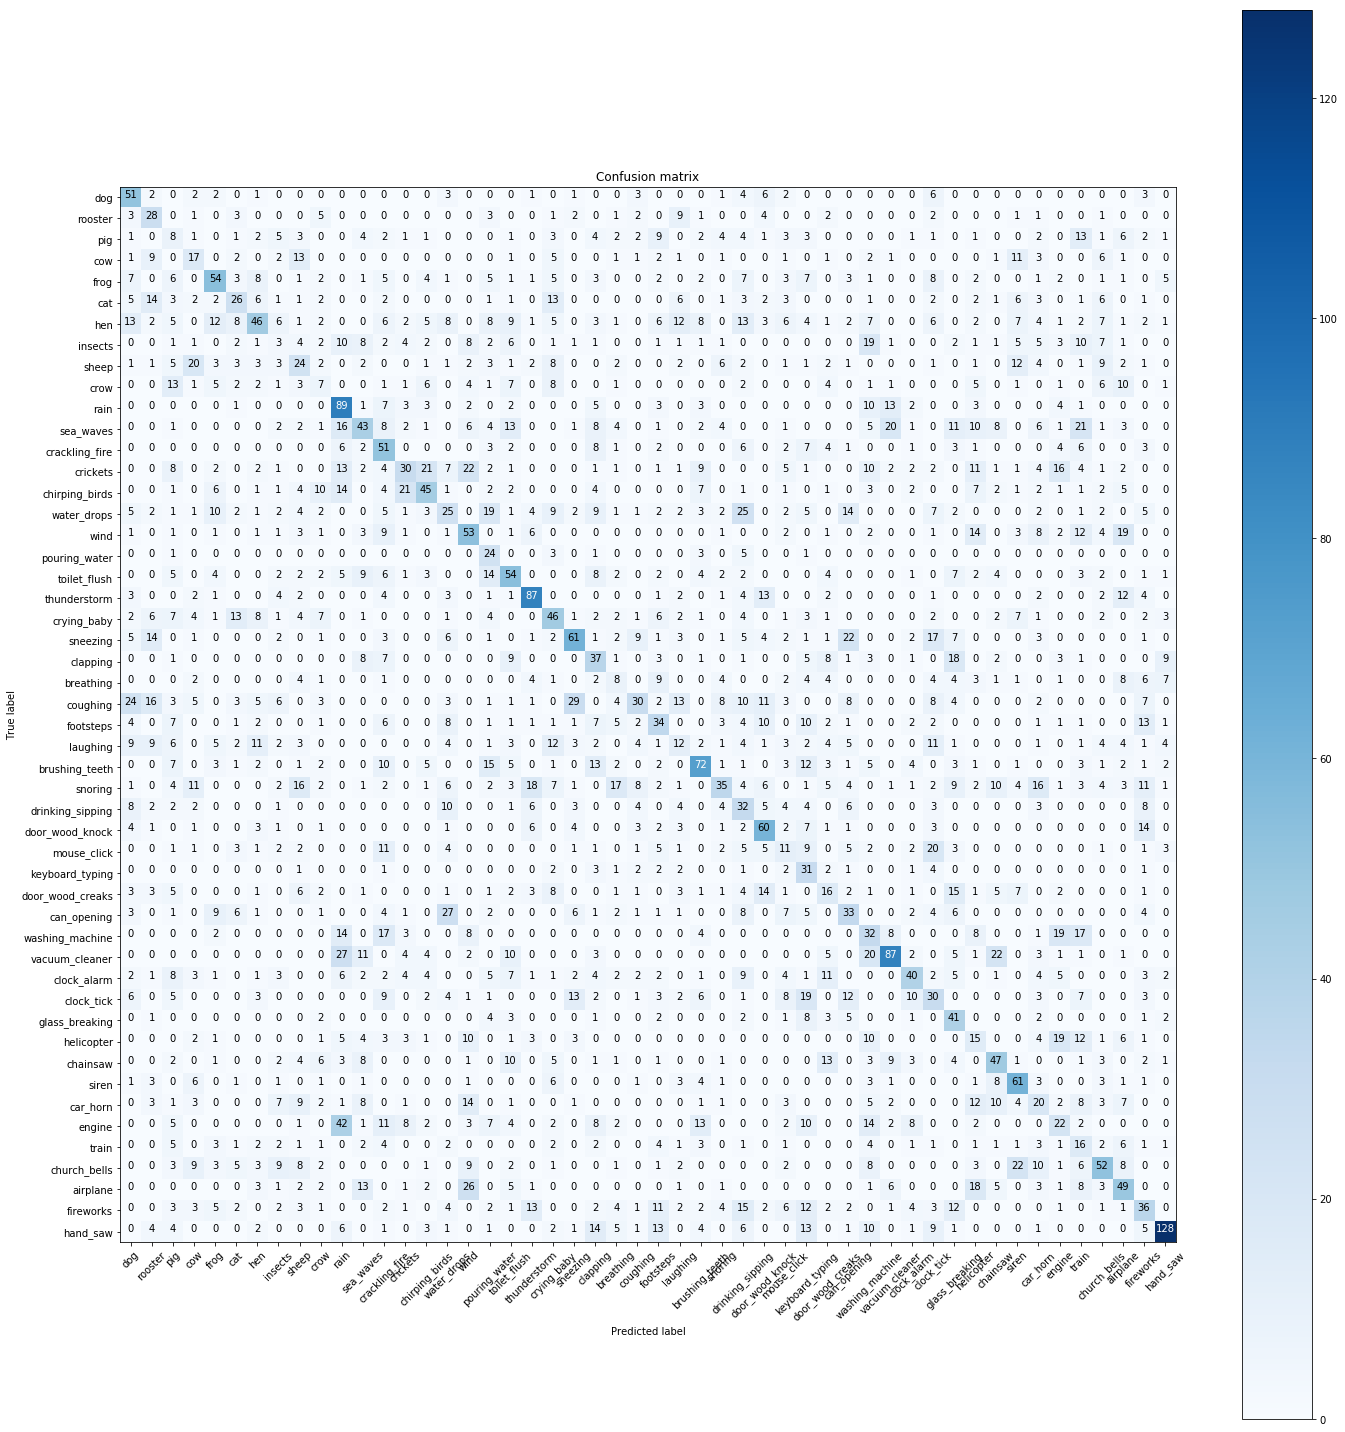

In [13]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y.values[:,1], pred))
cm = metrics.confusion_matrix(test_y.values[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [14]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [30]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

test = df[df.fold == 1]

for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.09184885025024414
	File Time: 0.052579402923583984
	File Time: 0.08657526969909668
	File Time: 0.057674407958984375
	File Time: 0.06248760223388672
	File Time: 0.057930707931518555
	File Time: 0.05296182632446289
	File Time: 0.15003252029418945
	File Time: 0.0654759407043457
	File Time: 0.07895159721374512
	File Time: 0.06714391708374023
	File Time: 0.23439478874206543
	File Time: 0.09383678436279297
	File Time: 0.2934110164642334
	File Time: 0.18776512145996094
	File Time: 0.12113189697265625
	File Time: 0.2482128143310547
	File Time: 0.1826341152191162
	File Time: 0.21245408058166504
	File Time: 0.2251906394958496
	File Time: 0.3003718852996826
	File Time: 0.23596906661987305
	File Time: 0.21682095527648926
	File Time: 0.09197402000427246
	File Time: 0.03554987907409668
	File Time: 0.1431894302368164
	File Time: 0.10796380043029785
	File Time: 0.20774292945861816
	File Time: 0.12410688400268555
	File Time: 0.0814363956451416
	File Time: 0.27111196517944336
	File Time: 0

	File Time: 0.1444871425628662
	File Time: 0.1397252082824707
	File Time: 0.13532710075378418
	File Time: 0.11584973335266113
	File Time: 0.12256383895874023
	File Time: 0.12539434432983398
	File Time: 0.06368136405944824
	File Time: 0.06063127517700195
	File Time: 0.13697576522827148
	File Time: 0.08549165725708008
	File Time: 0.08763384819030762
	File Time: 0.08935546875
	File Time: 0.0972297191619873
	File Time: 0.12545466423034668
	File Time: 0.07919740676879883
	File Time: 0.15264034271240234
	File Time: 0.10266900062561035
	File Time: 0.15133285522460938
	File Time: 0.18517613410949707
	File Time: 0.15544366836547852
	File Time: 0.06381940841674805
	File Time: 0.07918071746826172
	File Time: 0.049446821212768555
	File Time: 0.06606769561767578
	File Time: 0.31522560119628906
	File Time: 0.2632269859313965
	File Time: 0.10905051231384277
	File Time: 0.03624582290649414
	File Time: 0.2621583938598633
	File Time: 0.1956479549407959
	File Time: 0.4326903820037842
	File Time: 0.319409

0.44
Confusion matrix, without normalization
[[4 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 1 ... 0 3 0]
 [0 1 0 ... 0 0 9]]


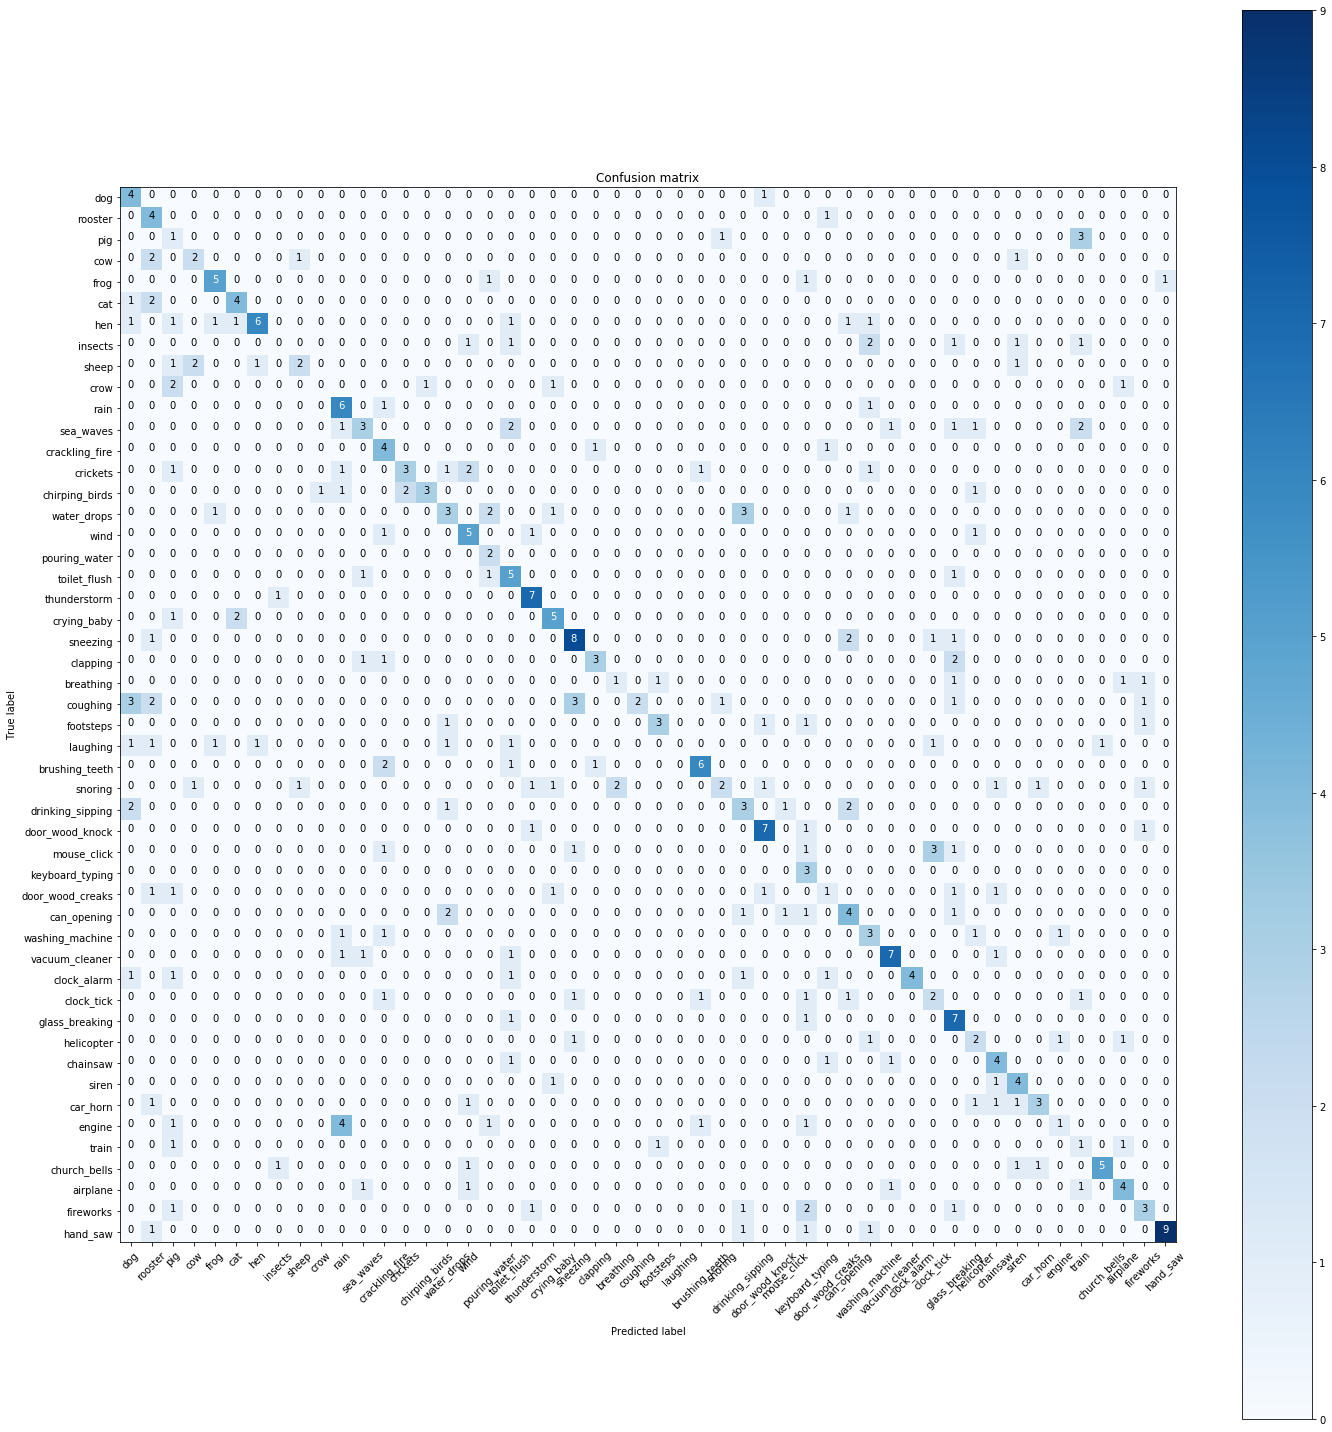

In [31]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [40]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

        yy_file = dataset.iloc[data_iloc].target
        
        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'actual': classes[yy_file],
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
        
    return predictions

In [41]:
%%time
preds = query_dataset('dog')

CPU times: user 25.2 s, sys: 1.14 s, total: 26.4 s
Wall time: 52.1 s


In [42]:
sorted_result = pd.DataFrame(preds).sort_values(by=['prob'], ascending=False).reset_index(drop=True)

In [35]:
sorted_result.head()

,ds_id,file,prediction,prob
0,56,1-172649-B-40.wav,"[6, 15, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 1...",0.208534
1,100,1-208757-B-2.wav,"[0, 3, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.207912
2,75,1-18527-B-44.wav,"[48, 0, 19, 0, 0, 38, 0, 0, 24, 0, 0, 1]",0.132362
3,79,1-18755-A-4.wav,"[30, 30, 29, 48, 38, 0, 0]",0.112723
4,319,1-67152-A-17.wav,"[0, 0, 0, 0, 30, 6, 0, 30, 31, 30, 0, 42, 15, ...",0.099295


In [36]:
# Checking index
misclass = []
for data_iloc in range(0, 20):
    row = sorted_result.iloc[data_iloc]
    if dataset.iloc[row.ds_id].target != classes.index('dog'):
        misclass.append(classes[dataset.iloc[row.ds_id].target])
        
print(misclass)

['helicopter', 'pig', 'engine', 'frog', 'pouring_water', 'chainsaw', 'sneezing', 'train', 'frog', 'helicopter', 'cat', 'cow', 'brushing_teeth', 'can_opening', 'airplane', 'sea_waves', 'mouse_click', 'chainsaw', 'chainsaw']


In [37]:
# Checking index
misclass = []
for data_iloc in range(0, 10):
    row = sorted_result.iloc[data_iloc]
    if dataset.iloc[row.ds_id].target != classes.index('dog'):
        misclass.append(classes[dataset.iloc[row.ds_id].target])
        
print(misclass)

['helicopter', 'pig', 'engine', 'frog', 'pouring_water', 'chainsaw', 'sneezing', 'train', 'frog', 'helicopter']
